In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

### Dados do teste

O teste foi realizado no bloco dos professores do IFPB-CG, do laboratório Assert(localização do gateway), no térreo, até o laboratório GComPI(localização do end-node), no subsolo, a distâncias entre esse dois laboratórios é aproximadamente  60 metros. Temos que ressaltar que o meio de transmissão é provido de vários obstáculos, entre eles, paredes densas, partes metálicas e equipamentos eletrônicos, o que dificulta a transmissão dos pacotes.

O gateway, ao receber os pacotes, envia para o servidor, hospedado na Microsoft Azure, os dados.

#### Get datas

In [3]:
packages = pd.read_json('packages.json')
sensors = pd.read_json('sensors.json')

#### Convert string time to datatime

In [4]:
packages['time'] = pd.to_datetime(packages['time'])
sensors['time'] = pd.to_datetime(sensors['time'])

#### Calculate the duration of the test

In [5]:
packages['time'].max() - packages['time'].min() 

Timedelta('1 days 17:06:10.223000')

#### Essential functions

In [16]:
# Filter a data frame by one date (format: yyyy-mm-dd)
def get_day(df: pd.DataFrame, date: str) -> pd.DataFrame:
    min = pd.Timestamp(date + ' 00:00:00', tz='UTC')
    max = pd.Timestamp(date + ' 23:59:59', tz='UTC')
    
    day = df[df['time'] >= min]
    day = day[day['time'] <= max]

    return day


# Get a panda series of PDR
def get_pdr(df: pd.DataFrame) -> pd.Series:
    success = pd.Series(df['success'].values, index=df['time'].dt.strftime('%H'))
    pdr = success.groupby(success.index).sum()
    
    return pdr


# Get two panda series of RSSI and your error
def get_rssi(df: pd.DataFrame) -> (pd.Series, pd.Series):
    r = pd.Series(df['rssi'].values, index=df['time'].dt.strftime('%H'))
    rssi = r.groupby(r.index).mean()
    rssi_error = r.groupby(r.index).std()
    
    return rssi, rssi_error


# Plot a pie graph of PDR percentual
def pie_graph(df: pd.DataFrame) -> None:  
    labels = ['Success', 'Error']
    pie = df['success'].value_counts()

    fig = plt.figure(figsize=(10, 10))
    plt.pie(pie, labels=labels, autopct='%0.2f%%', explode=[0, 0.05])

    day = df['time'].dt.strftime('%d/%m/%Y').values[0]
    plt.title('Transmitted packets at ' + day, fontsize=16)
    plt.show()


# Plot a bar grah of PDR and a line graph of RSSI
def pdr_graph(df: pd.DataFrame) -> None: 
    day = df['time'].dt.strftime('%d/%m/%Y').values[0]
    rssi, rssi_error = get_rssi(df)
    pdr = get_pdr(df)
    
    fig, pdr_ax = plt.subplots(figsize=(18, 10))

    color = 'tab:cyan'

    pdr_lns = pdr_ax.bar(pdr.index, pdr.values / 12 * 100, color=color, label='Packet Delivery Ratio (PDR)')

    pdr_ax.set_xlabel('Hour', fontweight='bold')
    pdr_ax.tick_params(axis='y', labelcolor=color)
    pdr_ax.set_ylabel('Packet Delivery Ratio (PDR)', color=color, fontweight='bold')

    rssi_ax = pdr_ax.twinx()

    color = 'black'

    rssi_lns = rssi_ax.errorbar(rssi.index, rssi.values, yerr=rssi_error, color=color, fmt='--o', linewidth=2.0, capsize=5, label='RSSI (dBm)')

    rssi_ax.set_ylim((-120, -110))
    rssi_ax.set_ylabel('RSSI (dBm)', color=color, fontweight='bold')
    rssi_ax.tick_params(axis='y', labelcolor=color)

    lns = [pdr_lns] + [rssi_lns]
    labels = [l.get_label() for l in lns]

    plt.rcParams.update({'font.size': 16})
    plt.legend(lns, labels, loc=2, prop={'size': 16})
    plt.show()

    fig.savefig(day.replace('/', '-') + '-pdr-rssi.png')

## Day 1 - 21/04/2020
---

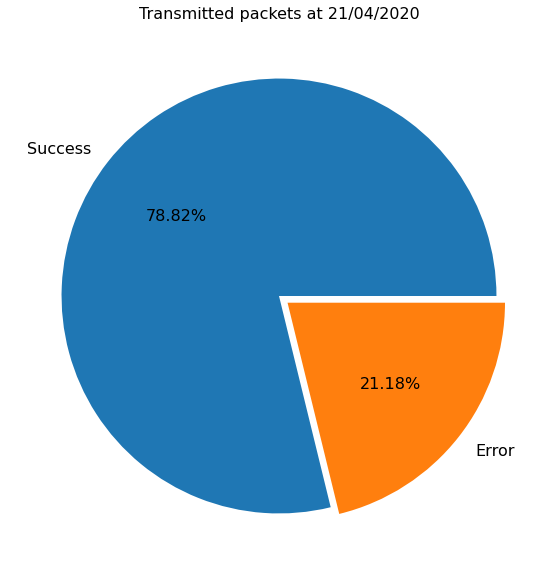

In [26]:
day = get_day(packages, '2020-04-21')
pie_graph(day)

#### RSSI médio e taixa de sucesso de entrega dos pacotes  por hora

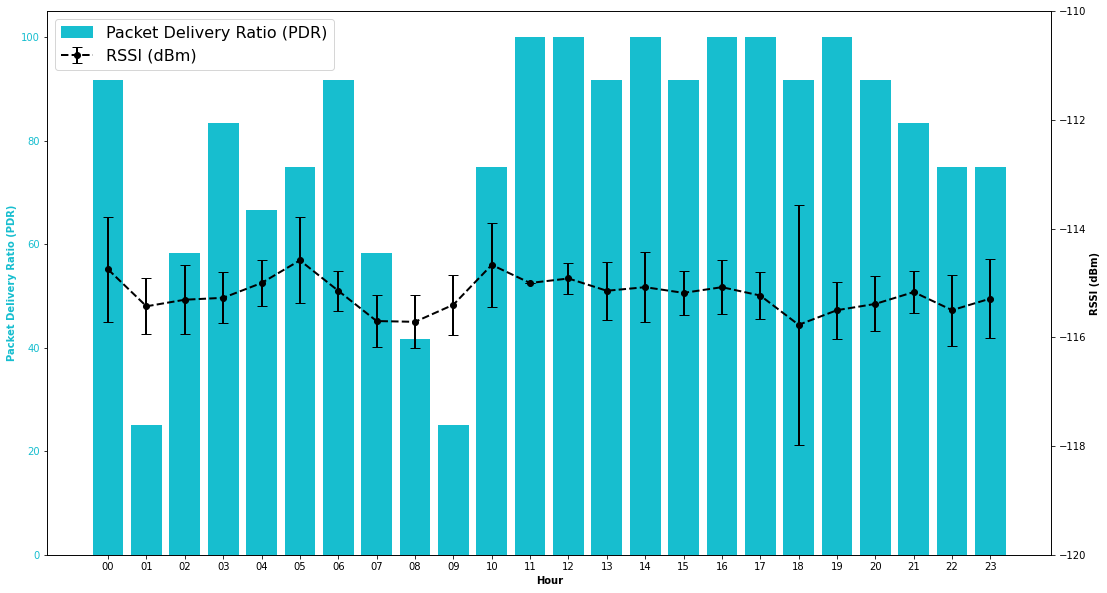

In [14]:
pdr_graph(day)